## Training GANs on the MNIST dataset

In this notebook, we are going to train a generative adversarial network on the MNIST digits. We are going to feed images from the MNIST dataset and those generated by our generator deep neural net, to the discriminator deep neural network. Along with the images, we will give a set of labels to the discriminator with a ~True label for images fed from the MNIST and ~False label for images fed from the generator.

While the above analysis has already been implemented, in this notebook we are going to try out two new concepts:

--- Label smoothing: The MNIST digits are noisy. There is no single representation of any digit in the dataset. Thus telling the discriminator that all the images in the dataset are perfect is not exactly right. Instead we will give it a soft classification label i.e. instead of giving a True (1) value to all the images coming from MNIST, we give it a 0.9 value. This means that the loss function will work in a way that does not maximize probability of seeing images from MNIST but approximately does that. Thus, the generator might try to learn to create images that are much better in form and consistency than the MNIST dataset.

--- The second and completely novel change that has been implemented in this analysis relates to the training of the two networks - Along with the true MNIST images and the ones generated from the generator, a third set of images with a pronouced defect are being fed to the discriminator. These images have been generated from the MNIST dataset with noise introduced. In a 28 x 28 image, the center 7 x 7 box has been turned to white. Also, the labels for this dataset have been given a really low weight as the images are highly distorted and not distinguishable. What is the reason of doing this? This could result in an improvement in the performance and the efficiency of the generator. The idea behind this implementation is that when the generator starts by generating its first batch of pictures, it only knows what the right implementation is from the correct MNIST dataset. It starts by generating a random image based on noise and then slows learns what is right and what is wrong. However, if we feed wrong images along with the right ones into the model from the start, it would know from the start what exactly to create and what not to create. This will result in faster learning for the generator and also in creating images that are more towards the actual images and far away from the noisy ones. Instead of the generator starting from a range of (any-random-image, MNIST), I have now restricted the range to (noisy MNIST, MNIST).


#### Reading in modules

In [51]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

#### Reading in the data

In [12]:
np.random.seed(100)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

#### Creating the GAN model

In [16]:
generator = Sequential()
generator.add(Dense(256, input_dim = randomDim, kernel_initializer = initializers.RandomNormal(mean = 0, stddev = 0.05)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim = 784, kernel_initializer = initializers.RandomNormal(mean = 0, stddev = 0.05)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(outputs = ganOutput, inputs = ganInput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_10 (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577.0
Trainable params: 2,946,577.0
Non-trainable params: 0.0
_________________________________________________________________


#### Defining the plotting functions

In [88]:
# Defining the plotting functions

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

To evaluate the difference in the performance of the normal GAN and our "Restricted, pre-trained" GAN, we will run the complete model with 15 epochs for both. We will record the number of iterations per second and also look at the loss of the generator and discriminator. For the comparison to be valid, the normal GAN has been given the same input data twice so that the size of the data for both the networks is the same.

#### Normal GAN

Epochs: 15
Batch size: 100
Batches per epoch: 600.0
--------------- Epoch 1 ---------------



100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:11<00:00,  3.12it/s]


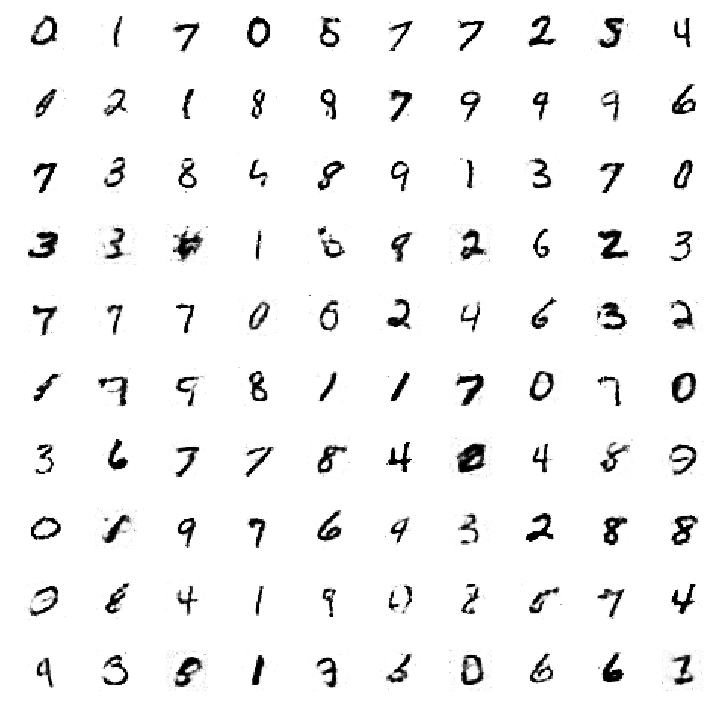

--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:57<00:00,  3.64it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:01<00:00,  2.69it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:23<00:00,  2.73it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:13<00:00,  3.06it/s]


--------------- Epoch 6 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:05<00:00,  3.95it/s]


--------------- Epoch 7 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:08<00:00,  3.43it/s]


--------------- Epoch 8 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:04<00:00,  3.42it/s]


--------------- Epoch 9 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:58<00:00,  3.22it/s]


--------------- Epoch 10 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:58<00:00,  3.02it/s]


--------------- Epoch 11 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:00<00:00,  3.26it/s]


--------------- Epoch 12 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:58<00:00,  3.51it/s]


--------------- Epoch 13 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:06<00:00,  3.10it/s]


--------------- Epoch 14 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:02<00:00,  3.54it/s]


--------------- Epoch 15 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:55<00:00,  3.60it/s]


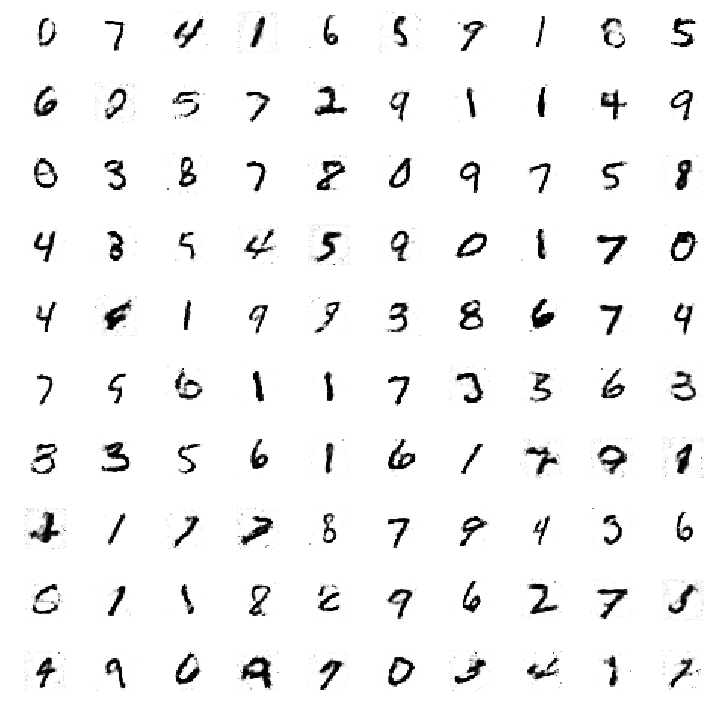

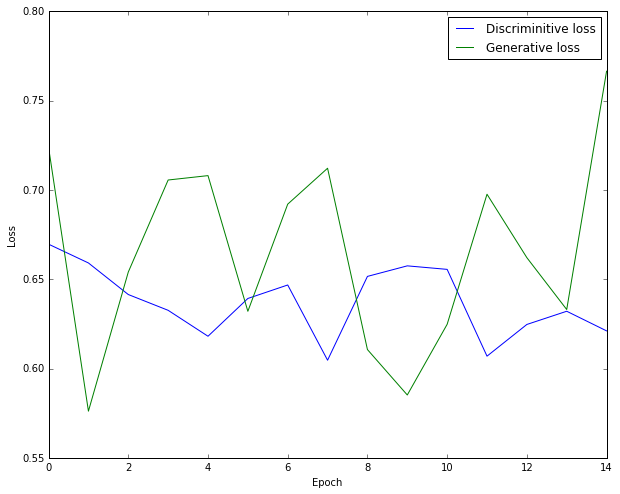

In [97]:
dLosses = []
gLosses = []

def train(epochs=1, batchSize=100):
    batchCount = X_train.shape[0] / batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(3*batchSize)
            # One-sided label smoothing
            yDis[:2*batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e == 15:
            plotGeneratedImages(e)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    train(15, 100)

#### "Restricted" GAN

Epochs: 15
Batch size: 100
Batches per epoch: 600.0
--------------- Epoch 1 ---------------



100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:34<00:00,  3.96it/s]


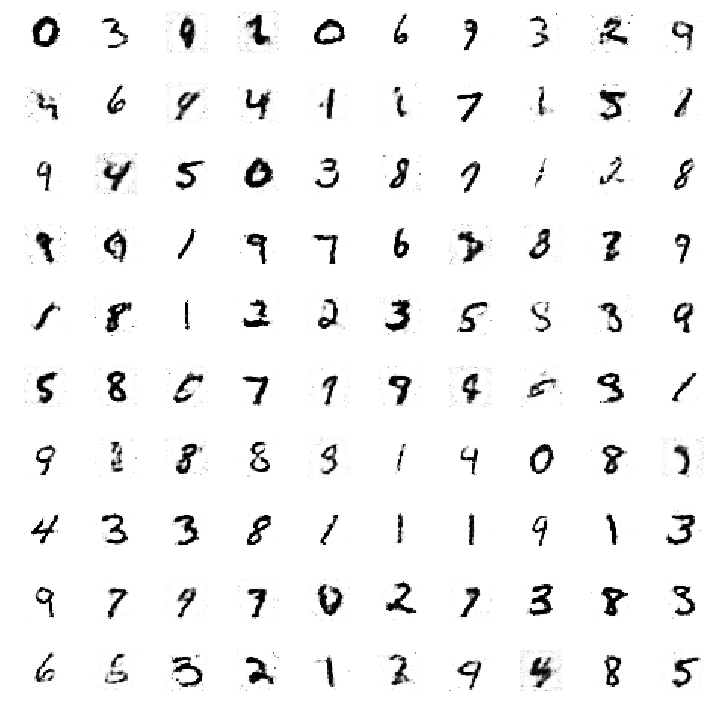

--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:39<00:00,  3.94it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:34<00:00,  3.92it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:33<00:00,  3.90it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:34<00:00,  3.89it/s]


--------------- Epoch 6 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:38<00:00,  3.91it/s]


--------------- Epoch 7 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:35<00:00,  3.95it/s]


--------------- Epoch 8 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:36<00:00,  3.91it/s]


--------------- Epoch 9 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:39<00:00,  3.62it/s]


--------------- Epoch 10 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:44<00:00,  3.72it/s]


--------------- Epoch 11 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:48<00:00,  3.79it/s]


--------------- Epoch 12 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:38<00:00,  3.96it/s]


--------------- Epoch 13 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:38<00:00,  3.43it/s]


--------------- Epoch 14 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:40<00:00,  3.67it/s]


--------------- Epoch 15 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:37<00:00,  3.99it/s]


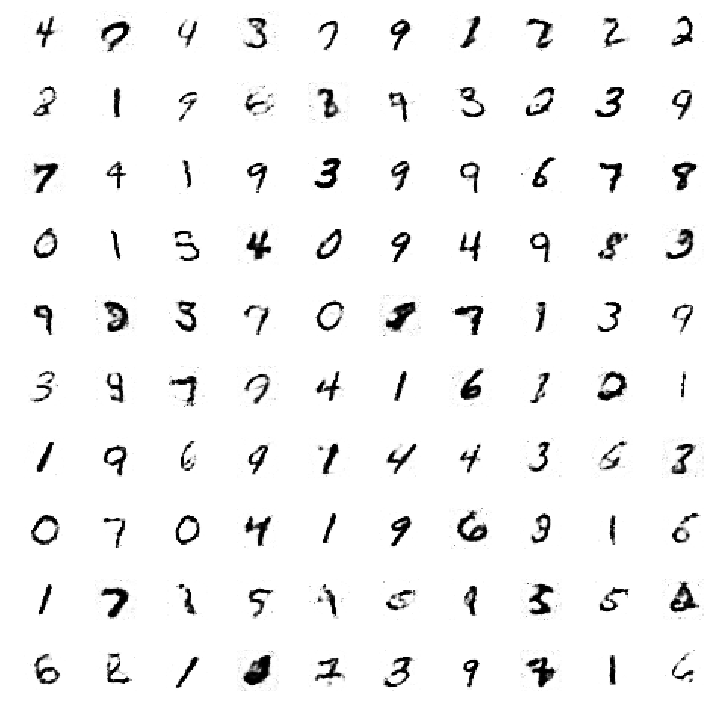

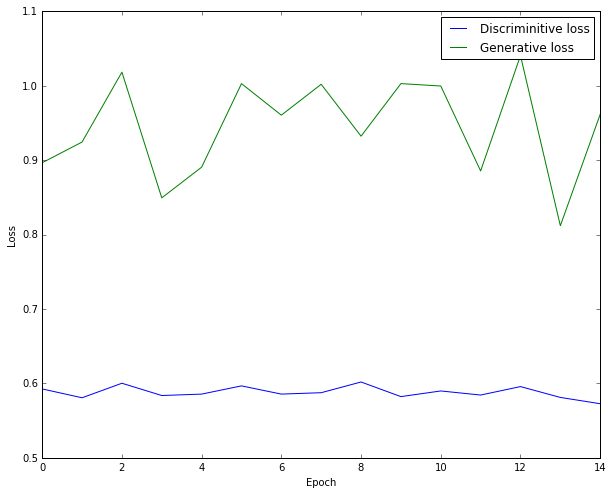

In [95]:
dLosses = []
gLosses = []

def train(epochs=1, batchSize=100):
    batchCount = X_train.shape[0] / batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
            
            ############### Generate images with fault in them
            imageBatch_noisy = imageBatch.copy()
            imageBatch_noisy = imageBatch_noisy.reshape(100, 28, 28)
            mask = np.zeros_like(imageBatch_noisy)
            mask[:, 10:18, 10:18] = 1
            mask = mask > 0.5
            imageBatch_noisy[mask] = -1
            imageBatch_noisy = imageBatch_noisy.reshape(100, 784)

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, imageBatch_noisy, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(3*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9
            yDis[batchSize : 2 * batchSize] = 0.9 * (64/728) + 0.1 

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e == 15:
            plotGeneratedImages(e)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    train(15, 100)

It is clear from the numbers we see that the number of iterations per second are higher for the new "Restricted" GAN implementation compared to the normal one. While the number of iterations in the "restricted" GANs are ~3.9 per second, the number is close to ~2.9 for the normal GAN. That is a significant increase.

Looking at the images of the digits generated, it is hard to say that there is a significant improvement in the quality of the images being produced. However, we have the loss chart for this.

From the lost chart, we can see that the start of the generator loss for the normal GAN is from a lower number compared to the restricted GAN. However, the normal GAN loss fluctuates a lot and is increasing rather than decreasing. The fluctuation in restricted GAN loss can be expected as the noise we add to the images as a higher effect on some digits like 6 compared to 0 or 1. Thus the loss will be higher when the proportion of those images is higher. It is decreasing overall though. The discriminator loss for the restricted GAN is very stable and also lower compared to the normal GAN. This is because the restricted GAN is being trained better in terms of what is good and what is not

#### Taking a look at the noisy images

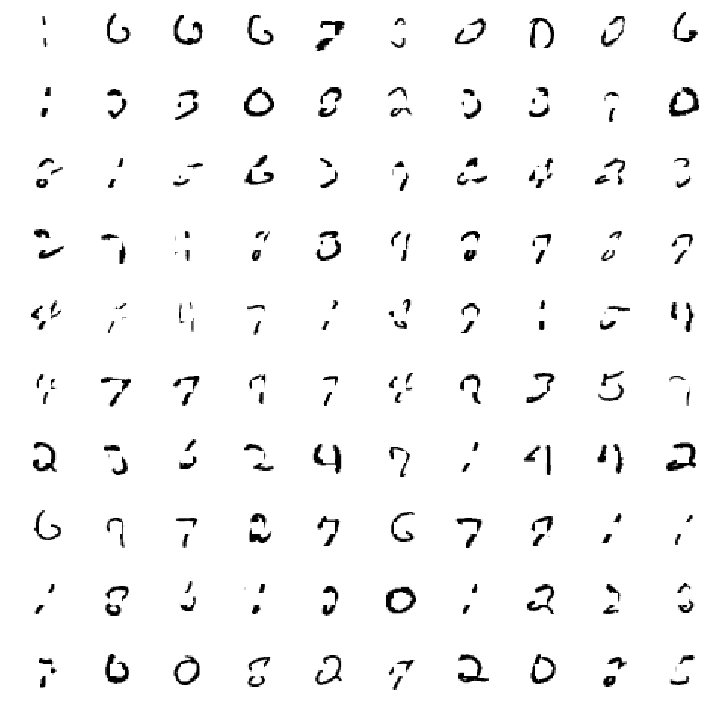

In [93]:
imageBatch_noisy = imageBatch.copy()
imageBatch_noisy = imageBatch_noisy.reshape(100, 28, 28)
mask = np.zeros_like(imageBatch_noisy)
mask[:, 10:18, 10:18] = 1
mask = mask > 0.5
imageBatch_noisy[mask] = -1

dim = (10, 10)

plt.figure(figsize= (10, 10))
for i in range(imageBatch_noisy.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(imageBatch_noisy[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

This is the most basic implementation of this idea. We can further explore the effects of using such an addition of noisy data in GANs. Some of the things we could try are:

I tried giving the noisy images a very high classification label of 0.8. This resulted in a very high discriminator loss. This is expected because we are saying that the noisy images are also almost as good as the original ones. Thus the classifier will not be able to figure out the right boundary between good and bad images. Along these lines, we could try a range of values (0, 1) of the correct and noisy classification labels.

Apart from this, we could introduce a myriad of defects in the images and study their effects on the loss and training efficiency. For example, we could use a black box instead of a white one or use the box in a corner.

We could also try to introduce a varying degree of defects and train the discriminator with all these images. Images could be distorted at various levels and this would result in a sort of partial learning.

The implementation of this idea on the MNIST dataset is just the start. When we move on towards RGB images, we could get completely different resutls - might not result in improvement or might result in a very high improvement. The fluctuating loss can be tackled by using the new OpenAI implementation of GANs.

Right now, I have used a deep neural net for training the discriminator and generator. We can implement this with a Deep Convolutional GAN and expect to see an improvement in performance because DCGANs work much better on images.  